<a href="https://colab.research.google.com/github/mann09/cds_mini_projects/blob/main/M2_MiniProject_5_Customer_Segmentation_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project Notebook: Customer segmentation using clustering

## Learning Objectives

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

## Grading = 10 Points

### Import Required packages

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

## Data Wrangling

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
!unzip -qq Online_Retail.zip

## Load the data

In [ ]:
# YOUR CODE HERE
retail_df = pd.read_csv("Online_Retail_Train.csv")

retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom


## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://kanoki.org/2020/04/23/how-to-remove-outliers-in-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [ ]:
# YOUR CODE HERE
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514813 entries, 0 to 514812
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    514813 non-null  object 
 1   StockCode    514813 non-null  object 
 2   Description  513428 non-null  object 
 3   Quantity     514813 non-null  int64  
 4   InvoiceDate  514813 non-null  object 
 5   UnitPrice    514813 non-null  float64
 6   CustomerID   386550 non-null  float64
 7   Country      514813 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 31.4+ MB


In [ ]:
len(retail_df.drop_duplicates())

510059

In [ ]:
pd.to_datetime(retail_df.InvoiceDate.str.replace("-",''), format='%Y%m%d %H:%M:%S.%f').dt.dayofweek

0         1
1         6
2         0
3         4
4         1
         ..
514808    6
514809    0
514810    2
514811    3
514812    3
Name: InvoiceDate, Length: 514813, dtype: int64

In [ ]:
stk_cd_fil = ['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES']

def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def clean_data(df):
  df = df.drop_duplicates()
  df = df[(df['InvoiceNo'].str[:1] !='C')|(df['InvoiceNo'].str[:1] !='A')]
  df = df.dropna()
  df = df[~df.StockCode.isin(stk_cd_fil)]
  df = df[df.Quantity>0]
  df_rmv_outlier = df
  df_stk_grp = df.groupby(['StockCode']).agg({'Quantity':[q1, q3], 'UnitPrice':[q1, q3]}).reset_index()
  df_stk_grp.columns = df_stk_grp.columns.map(''.join)

  df_rmv_outlier = pd.merge(df, df_stk_grp, on = 'StockCode')
  df_rmv_outlier['iqr_Quantity'] = df_rmv_outlier.apply(lambda x: x['Quantityq3'] - x['Quantityq1'] if (x['Quantityq3']-x['Quantityq1']>0) else x['Quantityq1'], axis =1)
  df_rmv_outlier['iqr_UnitPrice'] = df_rmv_outlier.apply(lambda x: x['UnitPriceq3'] - x['UnitPriceq1'] if (x['UnitPriceq3']-x['UnitPriceq1']>0) else x['UnitPriceq1'], axis =1)

  df_rmv_outlier['UL_Quantity'] = df_rmv_outlier['iqr_Quantity']*1.5
  df_rmv_outlier['UL_UnitPrice'] = df_rmv_outlier['iqr_UnitPrice']*1.5

  df_rmv_outlier['Quantity'] = df_rmv_outlier.apply(lambda x: x['Quantity'] if x['Quantity']<x['UL_Quantity'] else x['UL_Quantity'] ,axis=1)
  df_rmv_outlier['UnitPrice'] = df_rmv_outlier.apply(lambda x: x['UnitPrice'] if x['UnitPrice']<x['UL_UnitPrice'] else x['UL_UnitPrice'] ,axis=1)

  df_rmv_outlier['InvoiceDate_converted'] = pd.to_datetime(df_rmv_outlier.InvoiceDate.str.replace("-",''), format='%Y%m%d %H:%M:%S.%f')
  df_rmv_outlier['DayOfWeek'] = df_rmv_outlier['InvoiceDate_converted'].dt.dayofweek
  df_rmv_outlier['Month'] = df_rmv_outlier['InvoiceDate_converted'].dt.month
  return df_rmv_outlier


retail_df_cleaned = clean_data(retail_df)
retail_df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Quantityq1,Quantityq3,UnitPriceq1,UnitPriceq3,iqr_Quantity,iqr_UnitPrice,UL_Quantity,UL_UnitPrice,InvoiceDate_converted,DayOfWeek,Month
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2.0,2011-11-29 13:04:00,8.5,16479.0,United Kingdom,2.0,4.0,8.5,8.5,2.0,8.5,3.0,12.75,2011-11-29 13:04:00,1,11
1,542219,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2.0,2011-01-26 12:36:00,8.5,17735.0,United Kingdom,2.0,4.0,8.5,8.5,2.0,8.5,3.0,12.75,2011-01-26 12:36:00,2,1
2,545705,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2.0,2011-03-07 09:00:00,8.5,15554.0,United Kingdom,2.0,4.0,8.5,8.5,2.0,8.5,3.0,12.75,2011-03-07 09:00:00,0,3
3,575787,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2.0,2011-11-11 11:18:00,8.5,12518.0,Germany,2.0,4.0,8.5,8.5,2.0,8.5,3.0,12.75,2011-11-11 11:18:00,4,11
4,548159,22636,CHILDS BREAKFAST SET CIRCUS PARADE,3.0,2011-03-29 13:32:00,8.5,15906.0,United Kingdom,2.0,4.0,8.5,8.5,2.0,8.5,3.0,12.75,2011-03-29 13:32:00,1,3


## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

In [ ]:
# YOUR CODE HERE
print("# of Free Items")
retail_df_cleaned[retail_df_cleaned.UnitPrice==0]['Description'].unique()

# of Free Items


array(['CHRISTMAS PUDDING TRINKET POT ', 'SET OF 9 BLACK SKULL BALLOONS',
       'PASTEL COLOUR HONEYCOMB FAN', 'PARTY BUNTING',
       'HEART GARLAND RUSTIC PADDED', 'REGENCY CAKESTAND 3 TIER',
       "CHILDREN'S APRON DOLLY GIRL ", 'SET OF 6 NATIVITY MAGNETS ',
       'HANGING METAL HEART LANTERN', '36 FOIL STAR CAKE CASES ',
       'BISCUIT TIN VINTAGE CHRISTMAS', 'ORGANISER WOOD ANTIQUE WHITE ',
       'FAIRY CAKES NOTEBOOK A6 SIZE', 'GLASS CLOCHE SMALL',
       'MINI LIGHTS WOODLAND MUSHROOMS',
       'MINI CAKE STAND  HANGING STRAWBERY', 'POLKADOT RAIN HAT ',
       'ASSTD DESIGN 3D PAPER STICKERS', 'SET OF 2 TRAYS HOME SWEET HOME',
       'PLASTERS IN TIN SKULLS', ' OVAL WALL MIRROR DIAMANTE ',
       'JAM MAKING SET WITH JARS', 'CERAMIC BOWL WITH LOVE HEART DESIGN',
       'ROUND CAKE TIN VINTAGE GREEN', 'JUMBO BAG SPACEBOY DESIGN',
       'SET OF 2 CERAMIC PAINTED HEARTS ', 'PAPER BUNTING RETROSPOT',
       'PAPER BUNTING VINTAGE PAISLEY', 'ADVENT CALENDAR GINGHAM SACK',
     

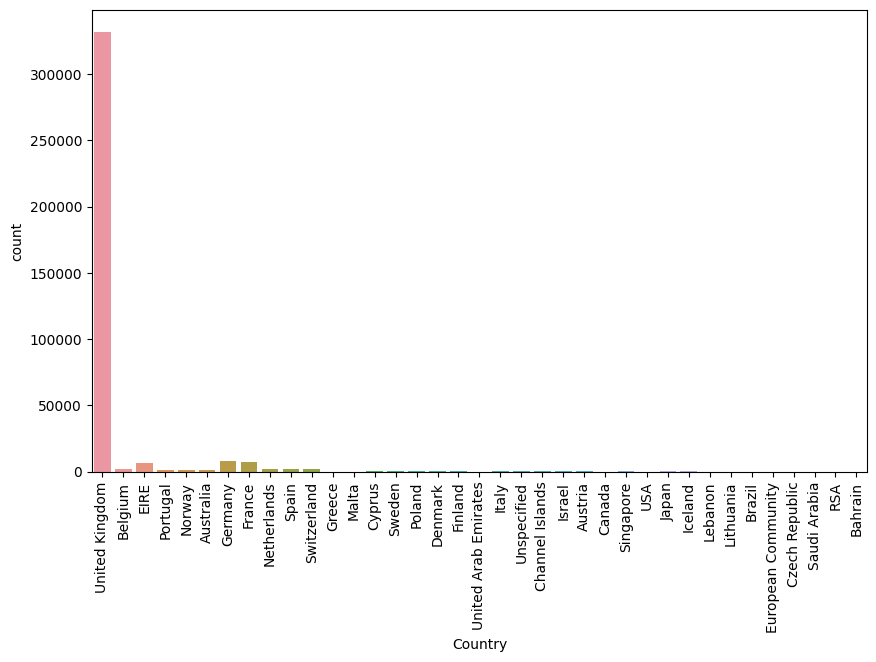

In [ ]:
# Transactions per country
tr_country = retail_df_cleaned.groupby('Country')['InvoiceNo'].count().reset_index()
plt.figure(figsize=(10,6))
sns.countplot(x='Country', data=retail_df_cleaned)
plt.xticks(rotation=90)
plt.show()

## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [ ]:
retail_df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'InvoiceDate_converted',
       'DayOfWeek', 'Month'],
      dtype='object')

In [ ]:
retail_df_cleaned['UnitPrice'].describe()

count    371969.000000
mean          2.555799
std           3.375939
min           0.000000
25%           0.850000
50%           1.650000
75%           2.950000
max         187.500000
Name: UnitPrice, dtype: float64

In [ ]:
retail_df_cleaned['Quantity'].describe()

count    371969.000000
mean          7.394745
std         133.089717
min           0.375000
25%           2.000000
50%           4.000000
75%          10.500000
max       80995.000000
Name: Quantity, dtype: float64

In [ ]:
# YOUR CODE HERE
from scipy import stats
def create_features(df):
  print('total customers before grp',len(df.CustomerID))
  df = df[(df['Quantity'] > 1)&(df['UnitPrice'] > 0)]
  #df = df[df['UnitPrice'] > 3]
  df['TotalAmt'] = df['Quantity']*df['UnitPrice']

  #compute the most recent date in dataframe
  max_date = max(df['InvoiceDate_converted'])
  # Calculate recency
  df['recency'] = max_date - df['InvoiceDate_converted']
  df['recency'] = df['recency'].dt.days
  #print(df[df.CustomerID==12347.0])
  df_cust_grp = df.groupby(['CustomerID']).agg({'TotalAmt':'sum','InvoiceNo':lambda x: x.nunique(), 'recency':'min','DayOfWeek':lambda x: x.value_counts().index[0]}).reset_index()
  print('total customers after grp',len(df_cust_grp.CustomerID))
  return df_cust_grp

retail_df_feat = create_features(retail_df_cleaned)
retail_df_feat.columns = ['CustomerID', 'TotalAmt', 'PurchaseFrequency', 'MostRecentPurchaseDays', 'MostFrequentlyVisitedDay']

retail_df_feat

total customers before grp 371969


<ipython-input-70-67e0c3eb31c6>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-67e0c3eb31c6>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-67e0c3eb31c6>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



total customers after grp 4322


,CustomerID,TotalAmt,PurchaseFrequency,MostRecentPurchaseDays,MostFrequentlyVisitedDay
0,12346.0,12.48000,1,325,1
1,12347.0,2693.03250,7,1,1
2,12348.0,461.13125,4,74,3
3,12349.0,1022.27375,1,18,0
4,12350.0,256.07500,1,309,2
...,...,...,...,...,...
4317,18280.0,151.73750,1,277,0
4318,18281.0,45.27000,1,180,6
4319,18282.0,131.65000,2,7,4
4320,18283.0,1133.50500,15,3,2


In [ ]:
max(retail_df_cleaned['InvoiceDate_converted'])- max(retail_df_cleaned[retail_df_cleaned.CustomerID==12347.0]['InvoiceDate_converted'])

Timedelta('1 days 20:58:00')

In [ ]:
print(max(retail_df_cleaned['InvoiceDate_converted'])), print(max(retail_df_cleaned[retail_df_cleaned.CustomerID==12347.0]['InvoiceDate_converted']))

2011-12-09 12:50:00
2011-12-07 15:52:00


(None, None)

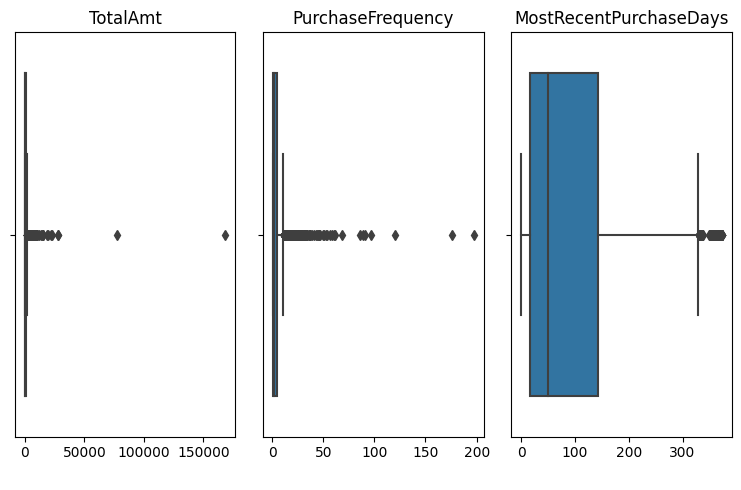

In [ ]:
# Detect outliers
fig = plt.figure(figsize = (10,5))
for i,j in enumerate(retail_df_feat[['TotalAmt','PurchaseFrequency','MostRecentPurchaseDays']]):
    ax = fig.add_subplot(1,4,i+1)
    ax = sns.boxplot(retail_df_feat, x = j)
    ax.set_title(j)
    ax.set_xlabel(' ')
plt.tight_layout()

In [ ]:
clean_list = ['TotalAmt','PurchaseFrequency','MostRecentPurchaseDays']
for x in clean_list:
    mean = np.mean(retail_df_feat[x])
    std = np.std(retail_df_feat[x])
    upper_outlier = [i for i in retail_df_feat[x] if i > mean+3*std]
    lower_outlier = [i for i in retail_df_feat[x] if i < mean-3*std]
    outlier = upper_outlier + lower_outlier
    retail_df_feat = retail_df_feat[~retail_df_feat[x].isin(outlier)]

### Scale the data

Apply `StandardScaler` on the features.

In [ ]:
# YOUR CODE HERE for scaling

# Scale data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Import model
scaler = MinMaxScaler()

numerical_columns = ['TotalAmt','PurchaseFrequency', 'MostRecentPurchaseDays']

retail_df_feat_scaled = retail_df_feat.copy()

#Transform each column
for i in numerical_columns:
    retail_df_feat_scaled[i] = scaler.fit_transform(retail_df_feat[[i]])

retail_df_feat_scaled = retail_df_feat_scaled.drop('MostFrequentlyVisitedDay', axis =1)
retail_df_feat_scaled

,CustomerID,TotalAmt,PurchaseFrequency,MostRecentPurchaseDays
0,12346.0,0.001101,0.000000,0.871314
1,12347.0,0.267964,0.315789,0.002681
2,12348.0,0.045766,0.157895,0.198391
3,12349.0,0.101631,0.000000,0.048257
4,12350.0,0.025352,0.000000,0.828418
...,...,...,...,...
4317,18280.0,0.014964,0.000000,0.742627
4318,18281.0,0.004365,0.000000,0.482574
4319,18282.0,0.012965,0.052632,0.018767
4320,18283.0,0.112705,0.736842,0.008043


## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

In [ ]:
# YOUR CODE HERE to apply KMeans
from sklearn.cluster import KMeans


inertia = []
num_clusters = list(range(1,10))

for k in num_clusters:
    #Instantiate model in range k
    kmeans = KMeans(n_clusters = k)
    #fit model
    kmeans.fit(retail_df_feat_scaled[numerical_columns])
    #append the SSE in k cluster to the list
    inertia.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

Text(0, 0.5, 'SSE')

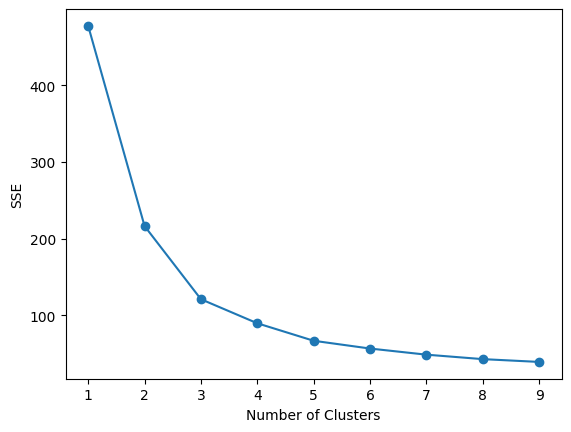

In [ ]:
# YOUR CODE HERE

plt.plot(num_clusters , inertia , 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [ ]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(retail_df_feat_scaled[numerical_columns])

#assign cluster in unscaled data set
retail_df_feat['cluster'] = kmeans.labels_
# +1 cluster
retail_df_feat['cluster'] = retail_df_feat['cluster'].apply(lambda x : x+1)

retail_df_feat['cluster'] = retail_df_feat['cluster'].astype('str')

retail_df_feat_scaled['cluster'] = kmeans.labels_
# +1 cluster
retail_df_feat_scaled['cluster'] = retail_df_feat_scaled['cluster'].apply(lambda x : x+1)

retail_df_feat_scaled['cluster'] = retail_df_feat_scaled['cluster'].astype('str')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


In [ ]:
# YOUR CODE HERE
# YOUR CODE HERE
from sklearn.cluster import DBSCAN

# Min points
min_points = 10

# Eps value
eps = 0.7

# Create the DBSCAN object
dbscan = DBSCAN(min_samples=min_points, eps=eps)

# Fit the model
db = dbscan.fit(retail_df_feat_scaled)

In [ ]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 4208


### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

In [ ]:
# YOUR CODE HERE
# ['TotalAmt','PurchaseFrequency','MostRecentPurchaseDays']
import plotly.express as px
fig = px.scatter_3d(retail_df_feat, x='TotalAmt', y='PurchaseFrequency', z='MostRecentPurchaseDays',
              color='cluster')
fig.show()

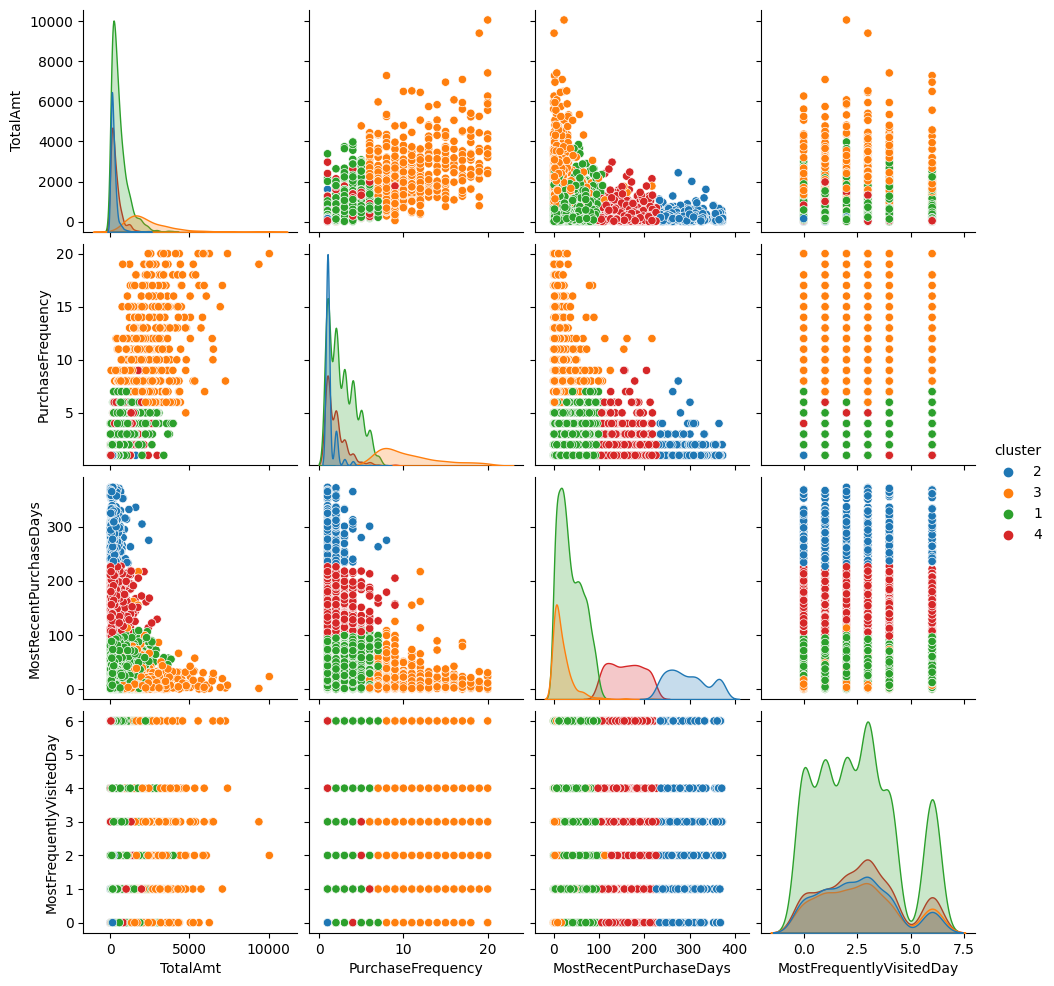

In [ ]:
sns.pairplot(retail_df_feat[['TotalAmt','PurchaseFrequency', 'MostRecentPurchaseDays', 'MostFrequentlyVisitedDay', 'cluster']],hue ='cluster')

### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [ ]:
# YOUR CODE HERE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Splitting the data into features (X) and target variable (y)
X = retail_df_feat.drop(['CustomerID', 'cluster'], axis=1)
y = retail_df_feat['cluster']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

class_counts = y.value_counts()
print(class_counts)

# Train the model on the training data
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

1    2312
4     749
2     605
3     560
Name: cluster, dtype: int64
Accuracy: 0.9943235572374646


### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [ ]:
# Test set provided as below
test = pd.read_csv("Online_Retail_Test.csv")
test.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom


### Report Analysis

- Discuss the pros and cons of removing the missing values vs replacing with the mean values
- Based on the visualization of clusters, comment on the difference in buying patterns of each cluster
- What other methods could be used to determine the optimal no. of clusters?